# Importazione delle librerie

Importiamo le librerie necessarie per lo svoglimento dei blocchi di codice

In [56]:
import cv2 as cv
import numpy as np
import va
import matplotlib.pyplot as plt

In [2]:
# conda install -c conda-forge vtk

In [3]:
# conda install -c conda-forge pyvista

In [4]:
# conda install -c conda-forge pythreejs

In [5]:
# pip install pyqt5

In [6]:
import pyvista as pv
from pyvistaqt import BackgroundPlotter
pv.set_jupyter_backend('pythreejs')  

# Filtri lineari

Le operazioni locali sono una tipologia di operazioni su immagini che utilizzano un insieme locale di pixel dell'immagine di partenza per determinare i pixel nel risultato.

Una delle operazioni locali più comuni sono i filtri lineari in cui il valore di ciascun pixel è calcolato come somma pesata dei valori dei pixel nell'intorno considerato 
$$
    I^{'}[y,x] = \sum_{i, j}w_{xy} \cdot F[i,j]
$$


$F$ è una matrice, solitamente di forma quadrata, aventi dimensioni $m \times m$ dove $m$ è dispari.
Gli elementi di $F$ sono chiamati coefficienti del filtro o, più comunemente, pesi.

<div>
    <img src="notebook_immagini_spiegazioni/esempio_filtro.png" />
</div>

Si fa riferimento ai coefficienti del filtro considerandfo due assi cartesiani con asse verticale rivolto verso il basso con origine in corrispondenza del centro di $F$.

La formula per il calcolo del valore di un pixel è scritta come:

$$
     I^{'}[y,x] = \sum_{i = -d}^{d}\sum_{j = -d}^{d} F[i,j] \cdot I[y + i, x + j], d = \lfloor \frac{m}{2} \rfloor
$$



## Gestione dei bordi 

Possono esservi dei punti, in prossimità dei bordi dell'immagine, in cui il filtro non può essere completamente sovrapposto a questa. Occorre gestire, in maniera analoga a quanto visto per le immagini, tali situazioni. 

Abbiamo varie possibilità : 
- Usare un valore di background costante (cv.BORDER_CONSTANT). 
- Copiare il valore del pixel più vicino (cv.BORDER_REPLICATE). 
- Riflessione dei pixel dell'immagine (cv.BORDER_REFLECT).





## Tipologia valori immagine di partenza

Solitamente per rappresentare l'immagine di partenza si adopera un byte per pixel ([0,255]), altri tipi comuni, tuttavia, possono essere degli interi con o senza segno (16 o 32 bit) o numeri floating point (32 o 64 bit). 
 
Solitamente questi ultimi casi sono frutto di risultati di precedenti applicazioni di filtri.
In caso di coefficienti negativi i pixel del risultato dovranno essere di tipo itero con segno o floating point.

**Normalizzazione del filtro** : Se i coefficienti sono tutti $\geq$ 0 e si vuole che i pixel dell'immagine abbiano lo stesso range di valori dell'immagine i partenza si normalizza il filtro dividendo per la somma dei coefficienti 

$$
\begin{bmatrix}
    0  & 2 & 1  \\
    2  & 5 & 0  \\
    3  & 1 & 0 
\end{bmatrix}
\Rightarrow
\frac{1}{14} \cdot
\begin{bmatrix}
    0  & 2 & 1  \\
    2  & 5 & 0  \\
    3  & 1 & 0 
\end{bmatrix}
\Rightarrow
\begin{bmatrix}
    0.0  & 0.14 & 0.07  \\
    0.14 & 0.36 & 0.0  \\
    0.21 & 0.07 & 0.0 
\end{bmatrix}
$$

**Normalizzazione immagine**: Si vogliono normalizzare i valori dei pixel in [0, 255] prima della visualizzazione.
- Immagini senza valori negativi: $I^{'}[y,x] = \frac{255}{max(I)} \cdot I[y,x]$
    - Il valore 0 in questo caso rappresenta il nero, il valore massimo dell'immagine rappresenta il bianco. 
- Immagini che contengono valori negativi: $I^{'}[y,x] = 128 + \frac{127}{max(abs(I))} \cdot I[y,x]$
    - Il valore 0 rappresenta il livello di grigio 128, i valori negativi rappresentano i livelli di grigio più scuro (fino al nero), i valori positivi rappresntano i livelli di grigio più chiaro (fino al bianco).


    

## Applicazione di un filtro lineare

Di seguito vengono mostrati due metodi in cui un filtro può essere applicato ad un immagine.

In [18]:
def filter2D_np(img, f):
    # Prendo le dimensioni dell' immagine
    h, w, = img.shape
    
    # Prendo le dimensioni del kernel f
    kh, kw = f.shape
    
    # Incremento la dimensione del bordo dell'immagine
    dy, dx = kh//2, kw//2
    imgb = cv.copyMakeBorder(img, dy, dy, dx, dx, cv.BORDER_DEFAULT)
    
    # Predispongo il vettore del risultato
    res = np.zeros(img.shape, dtype=np.int16)
    
    for y in range(h):
        for x in range(w):
            # imgb[y:y+kh, x:x+kw] restituisce una vista della matrice
            # imgb di dimensione kh x kw. Questa viene moltiplicata per 
            # la matrice filtro f e il risultato sommato e posizionato in 
            # res [y,x]
            res [y,x]  = (imgb[y:y+kh, x:x+kw]*f).sum()
    
    return res


def filter2D_cv(img, f): 
    # Semplice chiamata al metodo filter2D 
    # img è l'immagine a cui applicare il filtro
    # cv.CV_16S è la tipologia di data
    # f è la matrice da applicare 
    return cv.filter2D(img, cv.CV_16S, f)

Applichiamo il nostro filtro ad un immagine

filter2D_np: 256 ms ± 6.06 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
filter2D_cv: 395 µs ± 10.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)



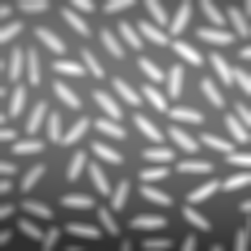
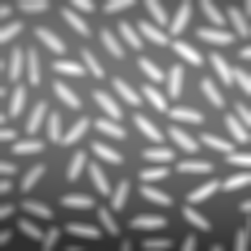

In [23]:
# Caricamento di un immagine
img = cv.imread("immagini/rice.png", cv.IMREAD_GRAYSCALE)

# Definisco un kernel semplice 
f = np.ones((9,9))

# Le funzioni sono oggetti Python, è possibile dunque immetterle
# All'interno di una lista. 
impl = [filter2D_np, filter2D_cv]

# Questo array ci servirà per contenere le immagini risultanti
out = []
for filter2D in impl: 
    print(filter2D.__name__, end=": ")
    %timeit filter2D(img, f)
    r = filter2D(img, f)
    out.append((r, f"{filter2D.__name__}"))

va.show(*out)


E' possibile notare da questa prova come la versione in OpenCV sia molto più veloce rispetto a quella numpy. 

## Filtri separabili

Se la matrice $F$ può essere ottenuta come prodotto di un vettore colonna per un vettore riga ($F = F_{y} \cdot F^{T}_{x}$), allora il filtro è separabile e si ha che 

$$
\begin{aligned}
I^{'}[y,x] = \sum_{i}\sum_{j} F_{y}[i] \cdot F_{x}[j] \cdot I[y + i , x + j] \\
= \sum_{i}F_{y}[i] \cdot \sum_{j}F_{x}[j] \cdot I[y + i , x + j]
\end{aligned}
$$

Dunque possiamo applicare il filtro in questo modo : 

$$
 \begin{aligned}
    I^{'}[y,x] = \sum_{i=-d}^{d} F_{y}[i] \cdot T[y + i, x]\\
    T[y,x] = \sum_{i=-d}^{d} F_{x}[j] \cdot I[y, x + j]
 \end{aligned} 
$$

In tal modo applichiamo prima il filtro $F_{x}$ avente dimensioni $ 1 \times m $ a tutta l'immagine ottenendo come immagine intermedia $T$ e successivamente applicare $F_{y}$, di dimensioni $m \times 1$ per ottenere $I^{'}$. 

Questo migliora notevolmente il costo computazionale in quanto nel caso di :

$$
     I^{'}[y,x] = \sum_{i = -d}^{d}\sum_{j = -d}^{d} F[i,j] \cdot I[y + i, x + j], d = \lfloor \frac{m}{2} \rfloor
$$

risulta essere di $m^{2}$ e invece, tramite filtri separabili diventa $2m$.

### Applicazione di un filtro separabile

Come prima vediamo come possiamo applicare un filtro separabile

sepFilter2D_np: 369 ms ± 7.85 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
sepFilter2D_cv: 99.1 µs ± 824 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)



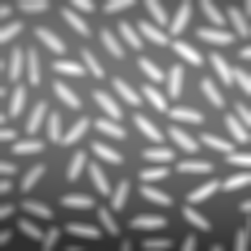
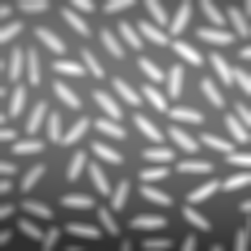

In [30]:
def sepFilter2D_np(img, fX, fY):
    """
    Filtri separabili implementazione in NumPy 
    """
    # Esegui il flatten degli array fX, fY
    fX, fY = fX.ravel(), fY.ravel()
    
    # Dimensioni dell'immagine
    h, w = img.shape
    
    # Dimensioni dei kernel
    kw, kh = fX.size, fY.size
    
    # Incremento del bordo destro e sinistro dell'immagine
    dy, dx = kh//2, kw//2
    imgb = cv.copyMakeBorder(img, 0, 0, dx, dx, cv.BORDER_DEFAULT)
    
    # Immagine intermedia
    t = np.empty(img.shape, dtype = np.int16)
    for y in range(h):
        for x in range(w): 
            t[y, x] = (imgb[y, x:x+kw] * fX).sum()
    
    # Incremento il bordo dell'immagine intermedia
    tb = cv.copyMakeBorder(t, dy, dy, 0, 0, cv.BORDER_DEFAULT)
    
    # Immagine risultato
    res = np.empty(img.shape, dtype = np.int16)
    for y in range(h):
        for x in range(w): 
            res[y, x] = (tb[y:y+kh, x] * fY).sum()
    
    return res

def sepFilter2D_cv(img, fX, fY): 
    """
    Filtri separabili implementazione in OpenCV
    """
    return cv.sepFilter2D(img, cv.CV_16S, fX, fY)


# Caricamento di un immagine
img = cv.imread("immagini/rice.png", cv.IMREAD_GRAYSCALE)

# Definizione dei kernel separabili 
fX, fY = np.ones((9,1)), np.ones((1,9))

# Le funzioni sono oggetti Python, è possibile dunque immetterle
# All'interno di una lista. 
impl = [sepFilter2D_np, sepFilter2D_cv]

# Questo array ci servirà per contenere le immagini risultanti
out = []
for filter2D in impl: 
    print(filter2D.__name__, end=": ")
    %timeit filter2D(img, fX, fY)
    r = filter2D(img, fX, fY)
    out.append((r, f"{filter2D.__name__}"))

va.show(*out)

## Correlazione e Convoluzione

Si definisce operazione di correlazione tra due elementi $I$ e $F$ l'operazione $I^{'} = I \otimes F$ definita come:

$$
     I^{'}[y,x] = \sum_{i = -d}^{d}\sum_{j = -d}^{d} F[i,j] \cdot I[y + i, x + j]
$$

Si definisce operazione di convoluzione tra due elementi $I$ e $F$ l'operazione  $I^{'} = I \ast F$ definita come : 

$$
     I^{'}[y,x] = \sum_{i = -d}^{d}\sum_{j = -d}^{d} F[i,j] \cdot I[y - i, x - j]
$$

la cui differenza è il cambio del segno degli offset.

### Proprietà algebriche degli operatori
Se un filtro $F$ è simmetrico rispetto l'origine allora $I \ast F = I \otimes F$. 

**proprietà comuni**
- Proprietà distributiva rispetto all'adizione: 
    - $I \otimes (F + G) = (I \otimes F)  + (I \otimes G)$
    - $I \ast (F + G) = (I \ast F)  + (I \ast G)$

- Proprietà associativa rispetto ad uno scalare
    - $(a \cdot I) \otimes F = a \cdot (I \otimes F)$
    - $(a \cdot I) \ast F = a \cdot (I \ast F)$

**SOLO LA CONVOLUZIONE È COMMUTATIVA E ASSOCIATIVA**
- $I \ast F = F \ast I$
- $(I \ast F) \ast G = I \ast (F \ast G)$


In OpenCV la funzione `cv.filter2D` implementa la correlazione. Per ottenere la convoluzione è succifiente prima ribaltare il filtro con `cv.flip(filtro, -1)`. 


## Utilizzo dei filtri

Di seguito vengono mostrate alcune applicazioni dei filtri 


### Box filter

Tipologia di filtro in cui tutti i pesi sono a 1. Viene solitamente normalizzato dividendo per il numero di elementi. 

L'effetto che produce l'applicazione di questo filtro è la sfocatura che attenua il contrasto locale e di conseguenza riduce il rumore all'interno dell'immagine.

In OpenCV è disponibile la funzione `boxFilter` 


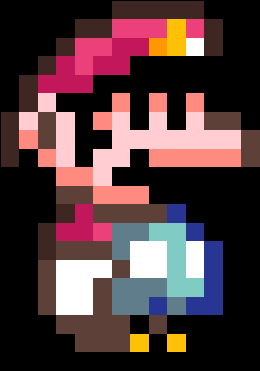
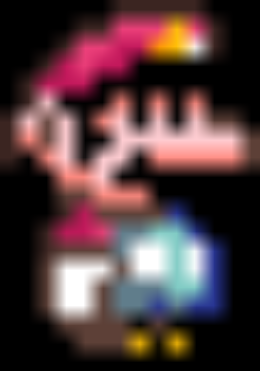


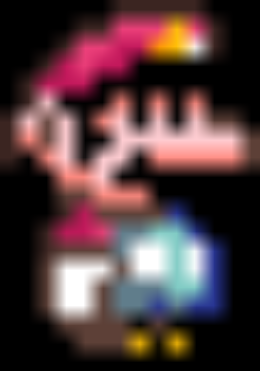
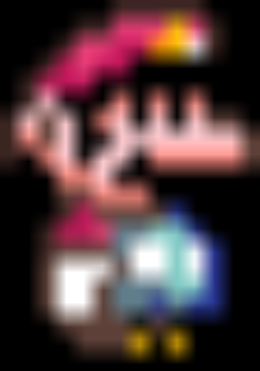
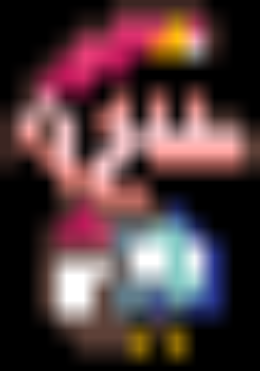
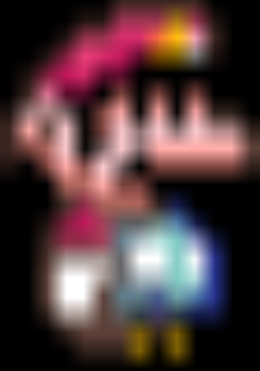
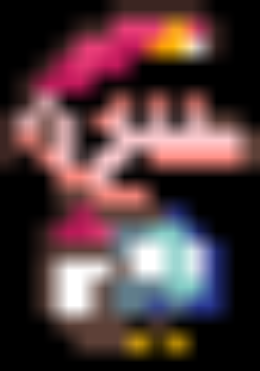
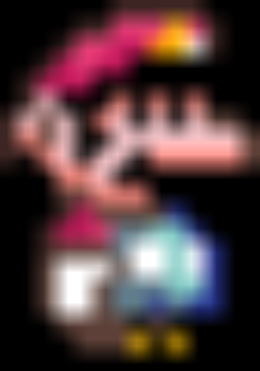
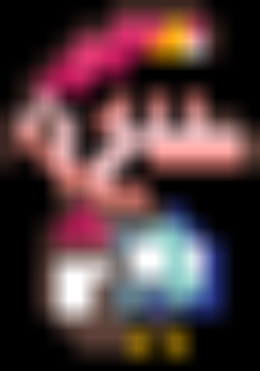
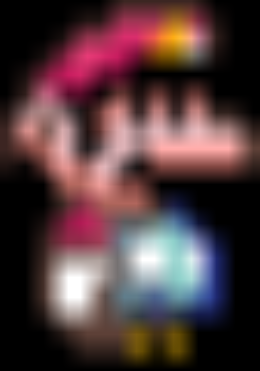
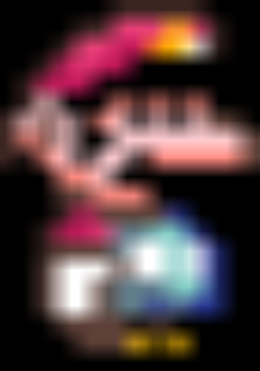
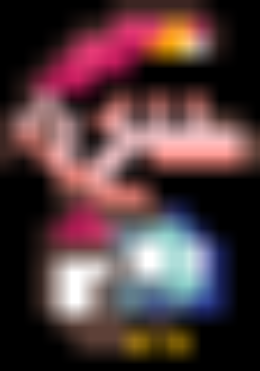
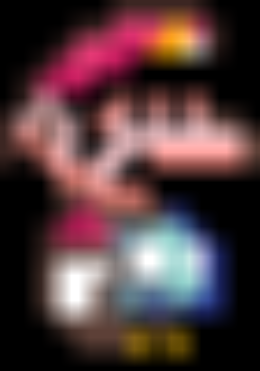
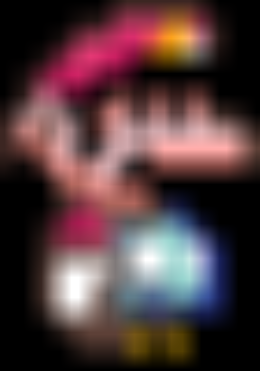
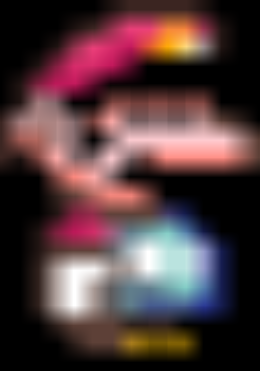
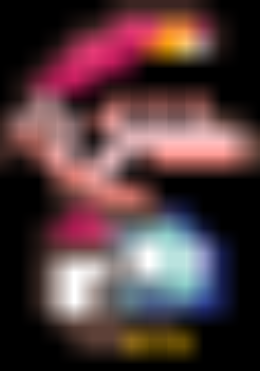
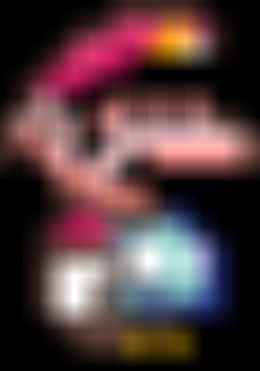
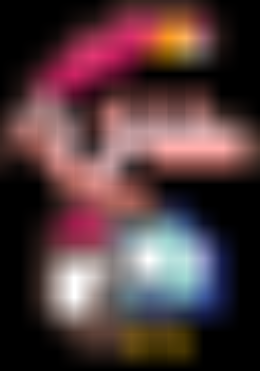

In [14]:
img = cv.imread("immagini/super-mario.png")

# Box filter normalizzato
smooth = cv.boxFilter(img, -1, (20,20), normalize=True)

va.show((img, "Originale"), (smooth, "Con filtro applicato"))

# E' possibile anche adoperare la funzione .blur()
# questa operazione è equivalente a richiamare boxFilter 
# con normalize=True
imgs = [
    (cv.blur(img, (kx, ky)), f"{kx} x {ky}")
    for kx in range(20, 40, 5)
    for ky in range (20, 40, 5)
]

# Mostro le immagini
va.show(*imgs, max_per_row=8)

Il box filter è semplice ed efficiente, tuttavia può produrre arteffati nell'immagine che possono essere visibili all'aumentare della dimensione del filtro. 

### Filtro gaussiano

Tipologia di filtro i cui pesi diminuiscono spostandosi dal centro verso l'esterno.

E' idale adoperare come riferimento una funzione Gaussiana in due dimensioni (produce filtri separabili).

**NOTA** : DISEGNARE I GRAFICI GAUSSIANI IN QUESTO PUNTO CON MATPLOTLIB



La funzione gaussiana in due dimensioni è definita come:

$$
    G_{2D}(x,y) = \frac{1}{2\pi\sigma^{2}}e^{-\frac{x^{2} + y^{2}}{2\sigma^{2}}}
$$

Che può essere scritta come 

$$
    G_{2D}(x,y) = \left( \frac{1}{\sigma\sqrt{2\pi}} \right)^{2}e^{-\frac{x^{2}}{2\sigma^{2}}}e^{-\frac{y^{2}}{2\sigma^{2}}}
$$


Essendo $G_{1D}(x) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{x^{2}}{2\sigma^{2}}}$ e $G_{1D}(y) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{y^{2}}{2\sigma^{2}}}$ allora possiamo vedere $ G_{2D}(x,y)$ come moltiplicazione di $G_{1D}(x)$ e $G_{1D}(y)$, quindi è separabile.


Per creare un filtro gaussiano $m \times m$ è necessario scegliere la dimensione di $m$ e di $\sigma$


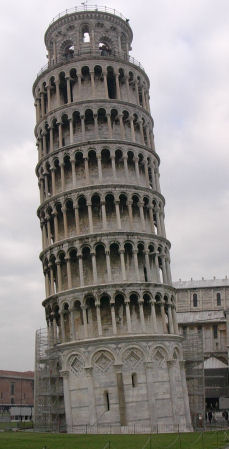
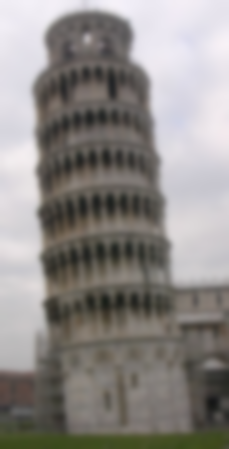

In [28]:
img = cv.imread("immagini/torre.jpg")

# Creazione di un filtro gaussiano 1D tramite la funzione
# getGaussianKernel. Il primo parametro specifica la dimensione m
# mentre il secondo il valore di 𝜎<
gk = cv.getGaussianKernel(90,3)
smooth = cv.sepFilter2D(img, -1, gk, gk)

# Funzione GaussianBlur
# Il secondo parametro è una tuplca contenente la dimensione del filtro
# Il terzo paramatro indica il valore di 𝜎
# Se 𝜎 <= 0 la funzione calcola 𝜎 come 𝜎 = 0.3*((m-1)*0.5 - 1) + 0.8
smoot_2 = cv.GaussianBlur(img, (5,5), 1)

va.show((img, "Immagine originale"), (smooth, "Applicazione del filtro"))

#### Lo sharpening

Possiamo sfruttare i filtri di blur che abbiamo visto per ottenere un miglioramento della messa a fuoco dell'immagine. 

- Si calcola un'immagine blurred tramite convoluzione con un filtro $F_{b}$ normalizzato. Possiamo scegliere in questo caso uno tra box filter o gaussiano. 
- Si sottrae l'immagine blurred all'originale creando l'immagine $M$. Questa conterrà dei pixel tendenti al nero nei punti in cui i pixel hanno mantenuto circa la stessa tonalità, mentre, nei punti in cui vi è un contrasto tra tonalità chiare e scure i pixel assumeranno tonalità chiare.

$$
    M = I - I \ast F_{b}
$$

- Si moltiplica $M$ per un parametro $k$ (controlla l'intensità dell'effetto):

$$
    I^{'} = I + k \cdot M
$$




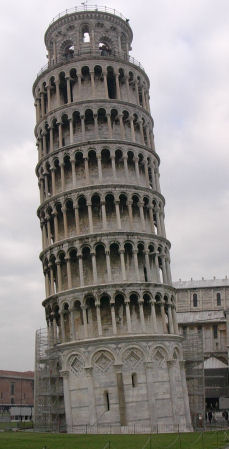
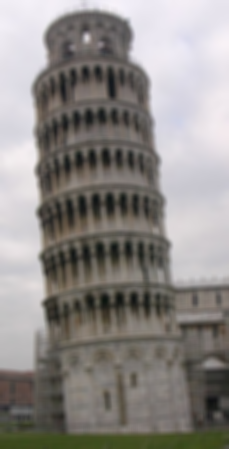
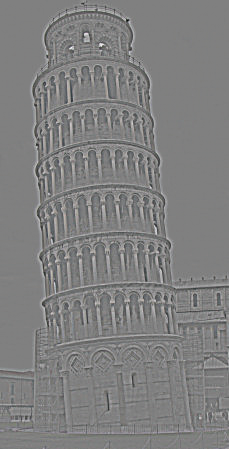
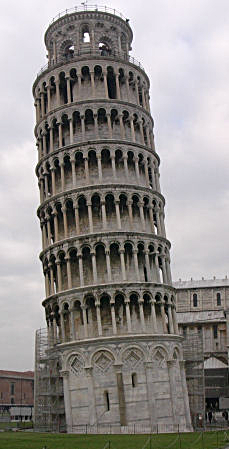

In [8]:
I = cv.imread("immagini/torre.jpg")

# Uso come filtro di blur un GaussianBlur
BI = cv.GaussianBlur(I, (7, 7), 3)

# Produco la matrice M
M = I.astype(np.int16) - BI

# Risultato
k = 0.5
I1 = np.clip(np.round(I.astype(float) + k * M), 0, 255).astype(np.uint8)

# Mostra le immagini
va.show((I, "I"), (BI, "BI"), (M, "I - BI"), (I1, "I + k * M"))

#### Filtro di sharpening unico
Possiamo sfruttare le proprietà algebriche della convoluzione per costruire un singolo filtro che esegue l'intera operazione di sharpening.
$$
   M = I - I \ast F_{b} = I \ast F_{id} + I \ast (-F_{b})
$$

**Nota**: $F_{id}$ è una matrice con un solo valore "1".

Possiamo applicare al contrario la proprietà distributiva $I \ast (F + G) = (I \ast F) + (I \ast G)$. 

$$
    M = I \ast F_{id} + I \ast (-F_{b}) = I \ast (F_{id}-F_{b}) \Rightarrow M = I \ast F_{L} \quad F_{L} = F_{id} - F_{b}
$$

Il risultato dello sharpening è $I^{'} = I + k \cdot M$ può essere scritto come $I^{'} = I + k \cdot (I \ast F_{L})$.
Possiamo applicare la proprietà associativa rispetto a uno scalre e commutativa si ottiente:

$$
    I^{'} = I + k \cdot (I \ast F_{L}) = I + I \ast (k \cdot F_{L})
$$

Applichiamo nuovamente la proprietà distributiva:

$$
    I^{'} = I + I \ast (k \cdot F_{L}) = I \ast F_{id} + I \ast (k \cdot F_{L}) = I \ast (F_{id} + (k \cdot F_{L}))
$$

Quindi possiamo ottenere $I^{'} = I \ast F_{s}$ con $F_{s} = F_{id} + (k \cdot F_{L}) = F_{id} + k \cdot (F_{id} - F_{b})$



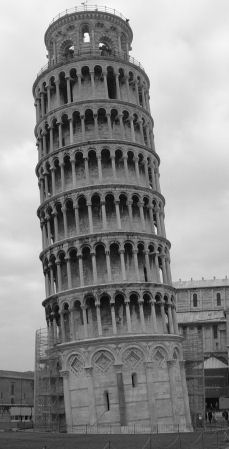
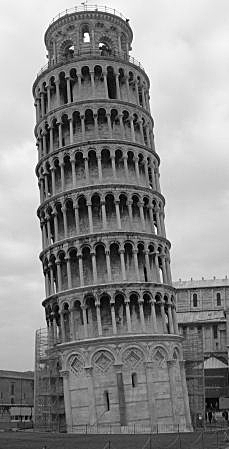

In [28]:
# Dimensione filtro 
m = 7

# Creo un kernell gaussiano 
gK = cv.getGaussianKernel(m,0)

# Creo il filtro di blur gaussiano e lo normalizzo
F_b = gK.reshape(1,-1) * gK
F_b /= F_b.sum()
w,h = F_b.shape

# Filtro identità 
F_id = np.zeros_like(F_b)
F_id[w//2, h//2] = 1

# Filtro finale, ottenuto tramite proprietà mostrate sopra
k = 0.7
f = F_id + k * (F_id - F_b)

res= cv.filter2D(I,-1, f)
va.show((I, "Originale"), (res, "Filtro sharpening unico"))

## Bordi

Un bordo è la separazione tra l'oggetto e :
- Lo sfondo dell'immagine
- Altri oggetti che compongono l'immagine. 

Questa informazione generalmente è più stabile rispetto alle informazioni di colore, tessitura, illuminazione e rumore.
L'estrazione dei bordi (edge detection) è molto importante e generalmente è usata come primo passo per l'individuazione di un oggetto in quanto permette di poter interpretare una forma geometrica. 

Considerata l'immagine $I$ come una funzione:

$$
     f: \mathbb{R} \times \mathbb{R} \rightarrow \mathbb{R}, \quad f(x,y) = I[y,x]
$$

i bordi si trovano in corrispondenza di cambiamenti rapidi di $f$





In [12]:
def mesh_from_image(img, plotter):
    """
    Trasforma un immagine in una mesh per pyvista
    """
    h,w = img.shape[:2]
    xx, yy = np.meshgrid(range(w), range(h))
    zz = img / 5.0
    points = np.c_[xx.flatten(), yy.reshape(-1), zz.reshape(-1)]
    surf = pv.PolyData(points).delaunay_2d()
    plotter.add_mesh(surf, scalars=img.reshape(-1), cmap="gray", smooth_shading=True)


# Mostra l'immagine.
# Roteandola è possibile vedere i cambiamenti di questa.
img = cv.imread("immagini/torre.jpg", cv.IMREAD_GRAYSCALE)
p =  pv.Plotter(notebook=True)
mesh_from_image(img,p)
p.show()

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(DirectionalLight(intensity=0.25, positi…

Precedentemente abbiamo potuto osservare che se sottraessimo il risultato dello smooth di un immagine dall'immagine originale otteniamo come risultato una nuova immagine in cui sono evidenziate le zone caratterizzate da cambiamenti rapidi fra valori chiari e scuri dei pixel.


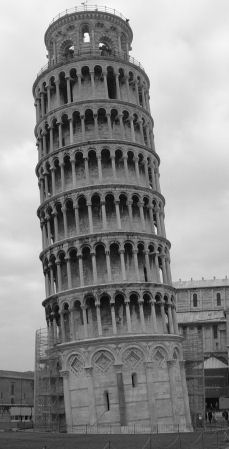
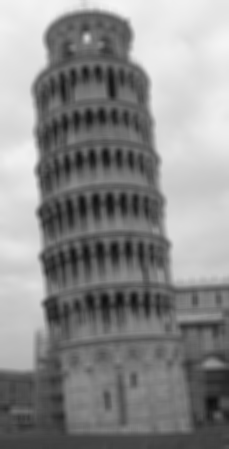
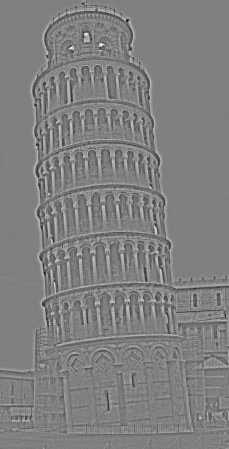

In [11]:
I = cv.imread("immagini/torre.jpg", cv.IMREAD_GRAYSCALE)
G = cv.GaussianBlur(I, (7,7), 5)
M = I.astype(np.int16) - G

va.show((I, "I"), (G, "Gb5"), (M, "I - Gb5"))

E' possibile notare questa cosa soprattutto visualizzando l'immagine in 3 dimensioni. 


In [13]:
mesh_from_image(M,p)
p.show()

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(DirectionalLight(intensity=0.25, positi…

### Difference of Gaussians (DoG)

Il filtro gaussiano riduce le alte frequenze nell'immagine:
- $I \ast G_{\sigma}$ contiene le basse frequenze dell'immagine.
- $I - (I \ast G_{\sigma})$ contiene le alte frequenze dell'immagine. 

Dati due filtri $G_{\sigma_{1}}$, $G_{\sigma_{2}}$ la differenza data da $(I \ast G_{\sigma_{1}}) - (I \ast G_{\sigma_{2}})$ evidenzia uno specifico range di frequenze nell'immagine.

Normalizzando questo risultato è possibile evidenziare i bordi di un determinato spessore. 


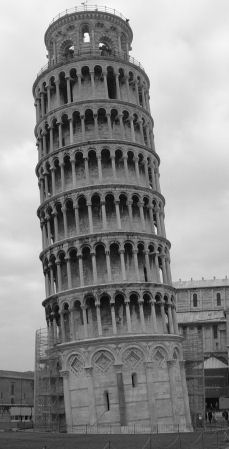
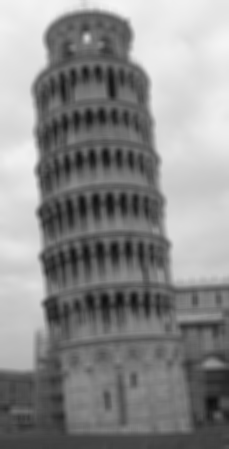
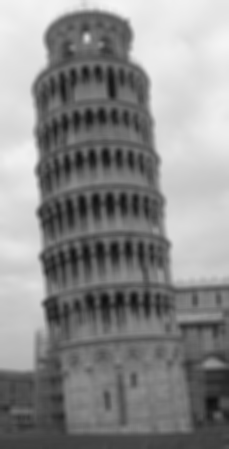
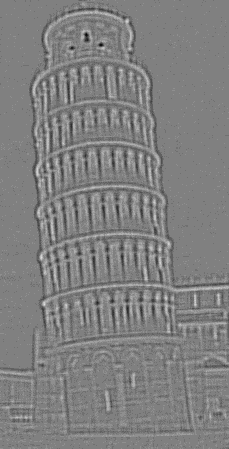
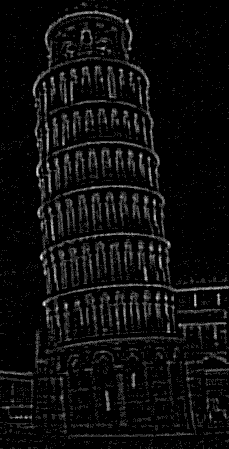

In [31]:
I = cv.imread("immagini/torre.jpg", cv.IMREAD_GRAYSCALE)
G1 = cv.GaussianBlur(I, (7,7), 5)
G2 = cv.GaussianBlur(I, (7,7), 3)
If = G1.astype(np.int16) - G2.astype(np.int16)
Inorm = np.clip(If, 0, 255)

va.show((I, "I"), (G1, "I * G1"), (G2, "I * G2"), (If, "(I * G1) - (I * G2)"), (Inorm, "Normalizzazione"),  max_per_row=5)

Applicando al contrario la proprietà distributiva $I \ast (F + G) = (I \ast F) + (I \ast G)$ si ha:

$$
(I \ast G_{\sigma_{1}}) - (I \ast G_{\sigma_{2}}) = I \ast (G_{\sigma_{1}} - G_{\sigma_{2}}) = I \ast DoG_{\sigma_{1},\sigma_{2}}
$$

L'operazione si può ottenere applicando un unico filtro ottenuto dalla differenza di due filtri gaussiani.

### Derivata di una funzione discreta:

La derivata di una funzione è data dal calcolo del rapporto incrementale
$$
    f^{'}(x) = \lim_{t \rightarrow 0} \frac{f(x+t) - f(x)}{t}
$$ 

Nelle immagini digitali abbiamo valori discreti, dunque, non è possibile calcolare esattamente il limite, ma possiamo stimarlo per un valore piccolo di $t$.

Stima del valore mediante differenza finita "centrata": 
$$
    f^{'}(x) \approx \frac{f(x+1) - f(x-1)}{2}
$$

<br/>
<div>
    <img src="notebook_immagini_spiegazioni/approx.png" />
</div>

L'immagine è una funzione discreta in due variabili:

$$
    \frac{\partial f(x,y)}{\partial x} \approx \frac{f(x+1, y) - f(x-1,y)}{2}
$$

$$
    \frac{\partial f(x,y)}{\partial y} \approx \frac{f(x, y + 1) - f(x,y - 1)}{2}
$$

#### Calcolo di derivate parziali attraverso un filtro

Vogliamo costruire ora un filtro che calcoli le nostre derivate parziali. 
Possiamo utilizzare l'operazione di correlazione:
$$
   \frac{\partial f(x,y)}{\partial x} =  I \otimes \frac{1}{2}\begin{bmatrix} -1 & 0 & 1 \end{bmatrix}
$$

$$
   \frac{\partial f(x,y)}{\partial y} =  I \otimes \frac{1}{2}\begin{bmatrix} -1 \\ 0 \\ 1 \end{bmatrix}
$$




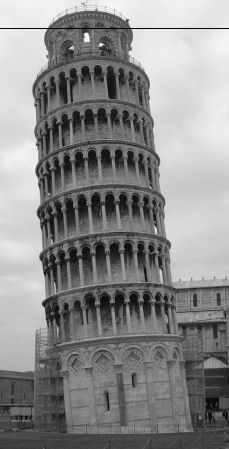

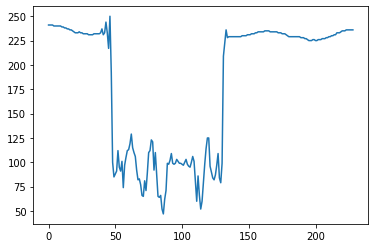

In [81]:
I = cv.imread("immagini/torre.jpg", cv.IMREAD_GRAYSCALE)
h,w = I.shape[:2]

# Manteniamo la y fissa e calcoliamo i valori dei pixel in quei punti.
yval = 28
y = I[28, :]
x = np.arange(0, w)

# Grafico dell'immagine in quel punto
plt.plot(x, y)

# Tracciamo una linea
cv.line(I,(0,yval),(w,yval),(0,0,0),1)
va.show(I)

In [114]:
np.array([[-1], [0], [1]])

array([[-1],
       [ 0],
       [ 1]])


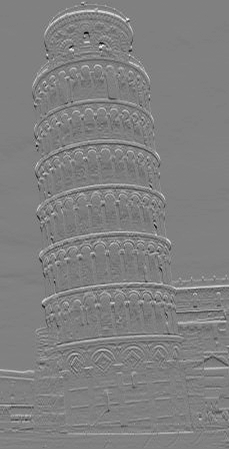
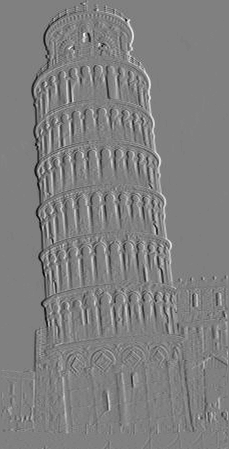

In [122]:
## Applichiamo all'immagine I il filtro delle nostre derivate parziali 
I = cv.imread("immagini/torre.jpg", cv.IMREAD_GRAYSCALE)
fx = cv.flip(0.5 * np.array([-1, 0, 1]), -1)
fy = cv.flip(0.5 * fx.reshape((1, -1)), -1)
Ifx = cv.filter2D(I.astype(np.int16), -1, fx)
Ify = cv.filter2D(I.astype(np.int16), -1, fy)

va.show((Ifx, "Derivata parziale fx"), (Ify, "Derivata parziale fy"))